# Tutorial: Using Sinusoidal Dataset in PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact

In [2]:
# manual seed for reproducibility
torch.manual_seed(85513)
np.random.seed(9991)

In [3]:
from SineGratesDataset import pil_to_tensor, SineGrates
transform = pil_to_tensor

In [4]:
cat_scheme = 'ii' # choose 'ii'(information-integration), 'rb'(rule-based)

Default parameters (per paper)

In [5]:
rb_params = {
    'a_means':[[30,50],[50,70]],
    'b_means':[[50,30],[70,50]],
    'a_covariances':[[[10,0],[0,150]],[[150,0],[0,10]]],
    'b_covariances':[[[10,0],[0,150]],[[150,0],[0,10]]]
}

ii_params = {
    'a_means':[40,50],
    'b_means':[60,50],
    'a_covariances':[[10,0],[0,280]],
    'b_covariances':[[10,0],[0,280]]
}

if cat_scheme == 'rb':
    dist_params = rb_params
elif cat_scheme == 'ii':
    dist_params = ii_params

A train and test dataset are created from the same kind of distribution

In [6]:
trainset = SineGrates(cat_scheme=cat_scheme, dist_params=dist_params, length=1000, transform=transform, randomize_phase=True)
testset = SineGrates(cat_scheme=cat_scheme, dist_params=dist_params, length=100, transform=transform, randomize_phase=True)

In [7]:
def modify_dist_params_ii(**kwargs):
    new_params = {
        'a_means':[kwargs['a_means_x'], kwargs['a_means_y']],
        'b_means':[kwargs['b_means_x'], kwargs['b_means_y']],
        'a_covariances':[[kwargs['a_cov_x'],0],[0,kwargs['a_cov_y']]],
        'b_covariances':[[kwargs['b_cov_x'],0],[0,kwargs['b_cov_y']]]
    }
    trainset.set_dist_params(new_params)
    testset.set_dist_params(new_params)
    plt.show(trainset.plot_final())
    plt.show(testset.plot_final())

In [8]:
def modify_dist_params_rb(**kwargs):
    new_params = {
        'a_means':[[kwargs['a_means_1_x'], kwargs['a_means_1_y']],
                   [kwargs['a_means_2_x'], kwargs['a_means_2_y']]],
        'b_means':[[kwargs['b_means_1_x'], kwargs['b_means_1_y']],
                   [kwargs['b_means_2_x'], kwargs['b_means_2_y']]],
        'a_covariances':[[[kwargs['a_cov_1_x'],0],[0,kwargs['a_cov_1_y']]],
                         [[kwargs['a_cov_2_x'],0],[0,kwargs['a_cov_2_y']]]],
        'b_covariances':[[[kwargs['b_cov_1_x'],0],[0,kwargs['b_cov_1_y']]],
                         [[kwargs['b_cov_2_x'],0],[0,kwargs['b_cov_2_y']]]],
    }
    trainset.set_dist_params(new_params)
    testset.set_dist_params(new_params)
    plt.show(trainset.plot_final())
    plt.show(testset.plot_final())

In [9]:
if cat_scheme == 'ii':
    interact(modify_dist_params_ii, 
             a_means_x = (0,80,1),
             a_means_y = (0,100,1),
             b_means_x = (0,120,1),
             b_means_y = (0,100,1),
             a_cov_x = (0,20,1),
             a_cov_y = (0,560, 1),
             b_cov_x = (0,20,1),
             b_cov_y = (0,560, 1),
            )
elif cat_scheme == 'rb':
        interact(modify_dist_params_rb, 
                 a_means_1_x = (0,60,1),
                 a_means_1_y = (0,100,1),
                 a_means_2_x = (0,100,1),
                 a_means_2_y = (0,140,1),
                 b_means_1_x = (0,100,1),
                 b_means_1_y = (0,60,1),
                 b_means_2_x = (0,140,1),
                 b_means_2_y = (0,100,1),
                 a_cov_1_x = (0,20,1),
                 a_cov_1_y = (0,300,1),
                 a_cov_2_x = (0,300,1),
                 a_cov_2_y = (0,20,1),
                 b_cov_1_x = (0,20,1),
                 b_cov_1_y = (0,300,1),
                 b_cov_2_x = (0,300,1),
                 b_cov_2_y = (0,20,1),
            )

interactive(children=(IntSlider(value=40, description='a_means_x', max=80), IntSlider(value=50, description='a…

## Generate the actual images from the above distribution

In [10]:
trainset.generate_dataset()
testset.generate_dataset()

As a sanity check, let's grab an example image

In [11]:
label, image = next(iter(trainset))

In [12]:
type(image)

torch.Tensor

In [13]:
image.shape

torch.Size([1, 256, 256])

# Loading the dataset into PyTorch

In [14]:
batch_size = 4

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=12)

In [16]:
classes = ['Condition A', 'Condition B']

In [17]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

dataiter = iter(trainloader)
labels, images = dataiter.next()

Check a sample of train dataloader

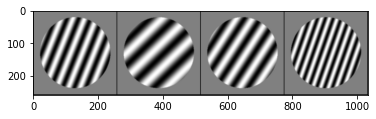

Condition A Condition A Condition A Condition B


In [18]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

And also check a sample of the test dataloader

In [19]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=12)
dataiter = iter(testloader)
labels, images = dataiter.next()

Define network

In [20]:
class LinearNet(nn.Module):
    '''
    Minimal 2-layer artificial neural network
    '''
    def __init__(self, num_classes: int = 2, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(256*256, 16, bias=True),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.flatten(x, 1)
        x = self.features(x)
        return x

In [21]:
net = LinearNet(num_classes=2)

In [22]:
# use GPU acceleration if available
if torch.cuda.is_available():
    net = net.cuda()

Define loss and optimizer

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [24]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        labels, images = data
        images = 2 * (images - 0.5002) # [0-1] to [-1,1]
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, loss: {running_loss:.3f}")
    running_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for i,data in enumerate(testloader,0):
            labels, images = data
            images = 2 * (images - 0.5002)
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = net(images)
            softmax_labels = F.log_softmax(outputs, dim=1)
            preds_classes = torch.argmax(softmax_labels, axis=-1)
            correct += int(torch.sum(preds_classes.cpu() == labels.cpu()))
            total += batch_size
        print(f"\tTest Accuracy: {100*correct/total:.3f} %")

Epoch 1, loss: 478.929
	Test Accuracy: 93.000 %
Epoch 2, loss: 80.642
	Test Accuracy: 95.500 %
Epoch 3, loss: 42.718
	Test Accuracy: 97.500 %
Epoch 4, loss: 58.281
	Test Accuracy: 94.000 %
Epoch 5, loss: 48.057
	Test Accuracy: 96.500 %
Epoch 6, loss: 30.120
	Test Accuracy: 96.000 %
Epoch 7, loss: 59.070
	Test Accuracy: 91.500 %
Epoch 8, loss: 65.774
	Test Accuracy: 93.000 %
Epoch 9, loss: 30.856
	Test Accuracy: 97.000 %
Epoch 10, loss: 42.115
	Test Accuracy: 97.500 %
